In [1]:
%load_ext autoreload
%autoreload 2

import cPickle as pickle
import os; import sys; sys.path.append('..'); sys.path.append('../gp/')
import gp
import gp.nets as nets

from nolearn.lasagne.visualize import plot_loss
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne.visualize import plot_conv_activity
from nolearn.lasagne.visualize import plot_occlusion

from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, precision_recall_fscore_support, f1_score, precision_recall_curve, average_precision_score, zero_one_loss


from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

%matplotlib inline

/home/d/nolearn/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using gpu device 0: GeForce GTX TITAN (CNMeM is disabled, CuDNN 4007)
/home/d/nolearn/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
NETS = []
NETS.append('../nets/IPMLB_FULL.p') # image + prob + binary + large border

network_path = NETS[-1]

with open(network_path, 'rb') as f:
    net = pickle.load(f)

In [2]:
# load cremi A data
import h5py
import mahotas as mh
import numpy as np
import tifffile as tif

In [3]:
input_image = np.zeros((125,1250,1250))
input_rhoana = np.zeros((125,1250,1250), dtype=np.uint64)
input_gold = np.zeros((125,1250,1250), dtype=np.uint64)
input_prob = np.zeros((125,1250,1250))

for z in range(125):
    image, prob, gold, rhoana = gp.Cremi.read_section('/home/d/data/CREMI/B/', z)
    input_image[z] = image
    input_prob[z] = prob
    input_gold[z] = gold
    input_rhoana[z] = rhoana

Loading 000000000_000000000_000000000_image.png
Loading 000000000_000000000_000000001_image.png
Loading 000000000_000000000_000000002_image.png
Loading 000000000_000000000_000000003_image.png
Loading 000000000_000000000_000000004_image.png
Loading 000000000_000000000_000000005_image.png
Loading 000000000_000000000_000000006_image.png
Loading 000000000_000000000_000000007_image.png
Loading 000000000_000000000_000000008_image.png
Loading 000000000_000000000_000000009_image.png
Loading 000000000_000000000_000000010_image.png
Loading 000000000_000000000_000000011_image.png
Loading 000000000_000000000_000000012_image.png
Loading 000000000_000000000_000000013_image.png
Loading 000000000_000000000_000000014_image.png
Loading 000000000_000000000_000000015_image.png
Loading 000000000_000000000_000000016_image.png
Loading 000000000_000000000_000000017_image.png
Loading 000000000_000000000_000000018_image.png
Loading 000000000_000000000_000000019_image.png
Loading 000000000_000000000_000000020_im

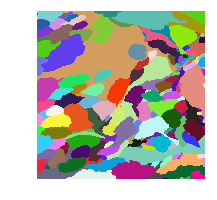

In [5]:
gp.Util.view(gold)

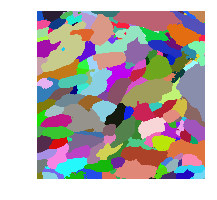

In [6]:
gp.Util.view(rhoana)

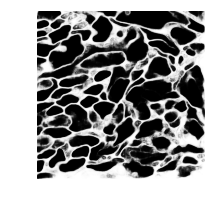

In [7]:
gp.Util.view(prob, color=False)

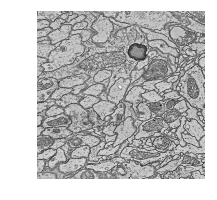

In [8]:
gp.Util.view(image, color=False)

In [9]:
gp.Util.vi(input_rhoana, input_gold)

1.6379129032154989

In [10]:
gp.metrics.adapted_rand(input_rhoana, input_gold)

0.53965521106464931

In [11]:
net.uuid = 'IPMLB'
bigM_cremiB = gp.Legacy.create_bigM_without_mask(net, input_image, input_prob, input_rhoana, verbose=True)

1868 generated in 35.2141709328 seconds.
Grouped into 347 patches in 0.00780010223389 seconds.
2032 generated in 41.558412075 seconds.
Grouped into 378 patches in 0.0088529586792 seconds.


In [14]:
bigM_cA_after_95, out_cA_volume_after_auto_95, cA_auto_fixes_95, cA_auto_vi_s_95 = gp.Legacy.splits_global_from_M_automatic(net, 
                                                                                                                            bigM_cremiB, 
                                                                                                                            input_image, 
                                                                                                                            input_prob, 
                                                                                                                            input_rhoana,
                                                                                                                            input_gold, 
                                                                                                                            sureness_threshold=.95)


In [15]:
gp.Util.vi(out_cA_volume_after_auto_95, input_gold)

2.2762014597371047

In [16]:
gp.metrics.adapted_rand(out_cA_volume_after_auto_95, input_gold)

0.67938306779292756

In [4]:
ar = []
for z in range(input_rhoana.shape[0]):
    ar.append(gp.metrics.adapted_rand(input_rhoana[z], input_gold[z]))

In [5]:
import collections

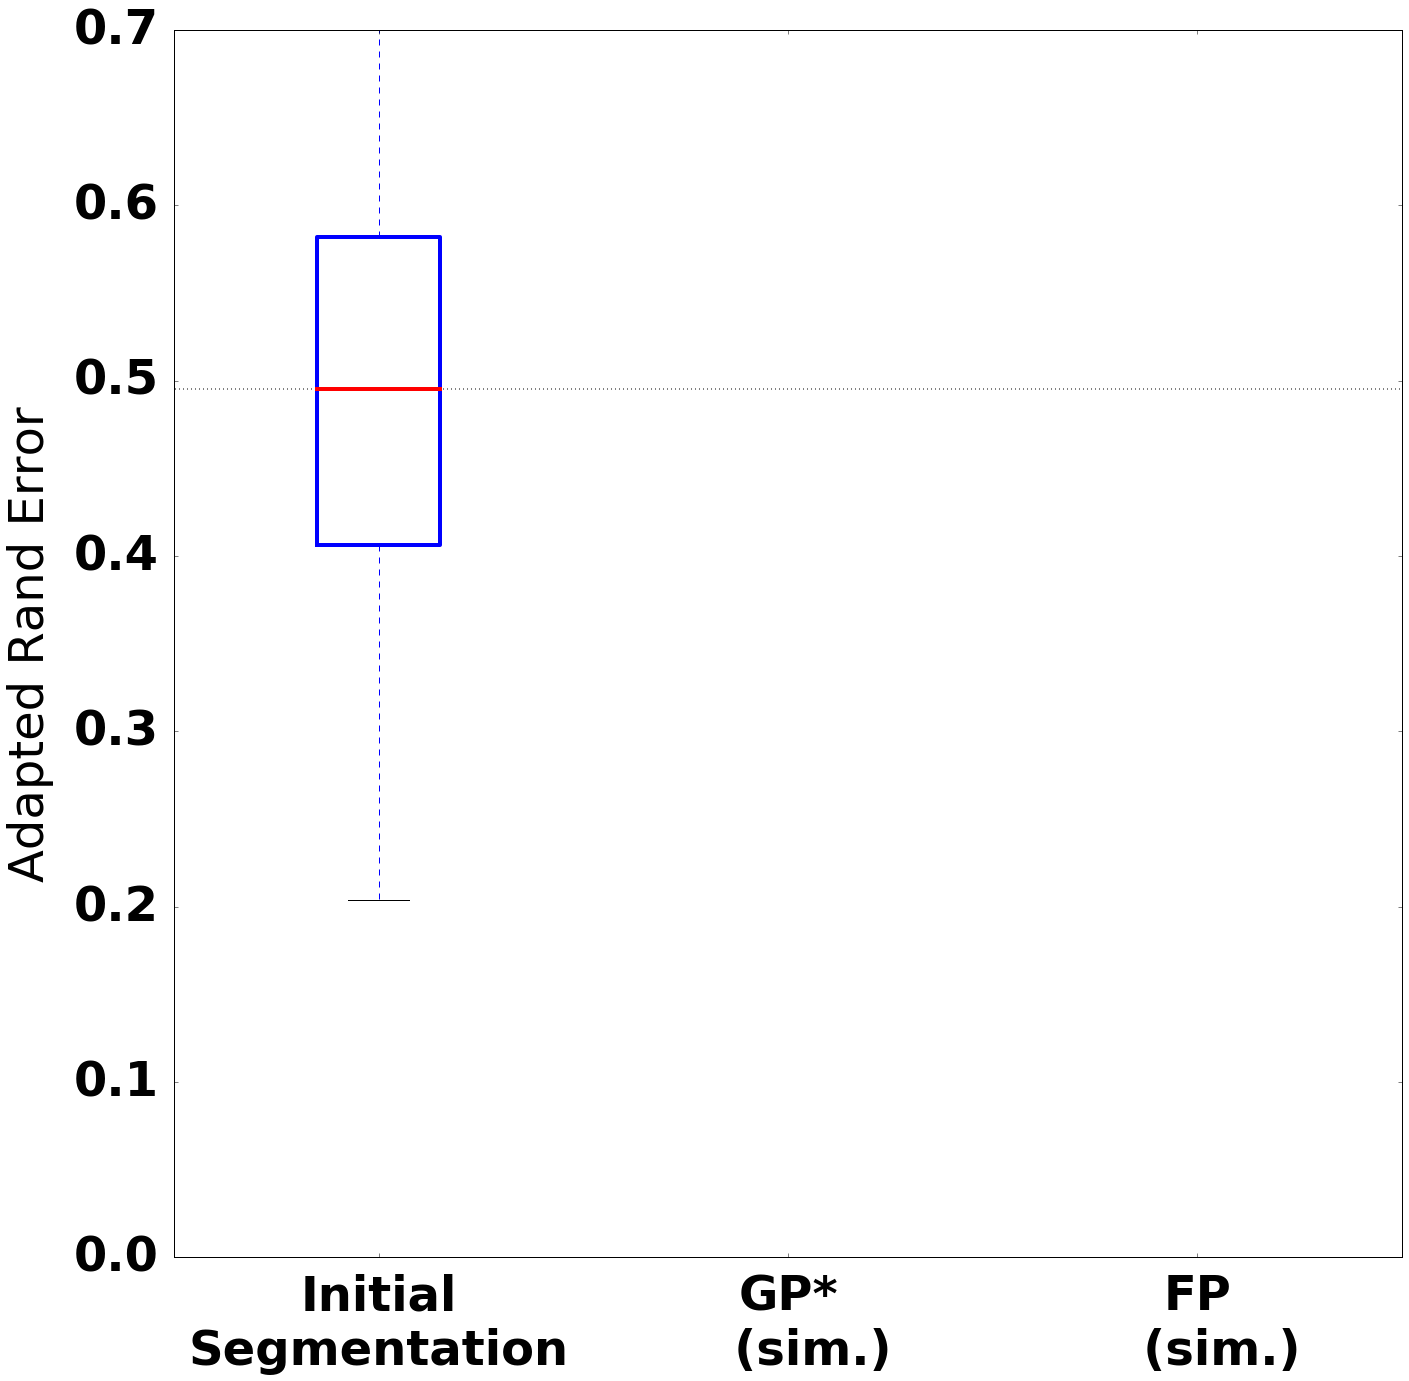

In [7]:
data = collections.OrderedDict()
data['Initial\nSegmentation'] = ar
data['GP*\n   (sim.)'] = []#cylinder_sim_user_vi_s[-1]
# data['GP*\n   (sim.)'] = []#[v - 0.1 for v in dojo_vi_95[2]]
data['FP\n   (sim.)'] = []#dojo_vi_95[2]

gp.Legacy.plot_arand(data, '/tmp/cremi.pdf')#, output_folder+'/dojo_vi.pdf')